In [1]:
import sys; sys.path.append('../')
import elastic_rods, scipy, numpy as np, time, matplotlib

import matplotlib.pyplot as plt

# from numpy.random import uniform as random
# from scipy.ndimage import gaussian_filter
# from scipy.signal import find_peaks
# from copy import copy, deepcopy
# import pickle
# import linkage_vis, vis
from bending_validation import suppress_stdout as so

# from helpers_forces import *
# from helpers_rods import boundingBox, compute_material_vars

import finite_diff

from linkage_vis import LinkageViewer as Viewer, CenterlineViewer
import vis
# from tri_mesh_viewer import LineMeshViewer, RawMesh
# from tri_mesh_viewer import PointCloudViewer, PointCloudMesh

# from helpers_rods import define_periodic_rod, define_periodic_circle, periodic_scalar_field

np.set_printoptions(formatter={'float_kind':"{:.6e}".format})
%load_ext autoreload
%autoreload 2

# Test periodic rod
 - [Derivatives, in blocks (ipc-toolkit)](#sec:derivatives_blocks_ipc)
 - [Derivatives, in blocks (sliding contacts)](#sec:derivatives_blocks_sliding)
 - [Derivatives close to the connection](#sec:derivatives_connection) 
 - [$\epsilon$-projection](#sec:projection)
 - [C-R interpolation](#sec:cr_interp)
 - [Visualisation](#sec:visualisation)
 - [Optimization](#sec:optimization)

----

# Test `PeriodicRodsList`'s derivatives

In [2]:
def define_periodic_rod(pts, material, rest_curv_rad=np.inf, twist=0.0):
    duplicated_0 = np.linalg.norm(pts[0, :] - pts[-2, :]) < 1e-12
    duplicated_1 = np.linalg.norm(pts[1, :] - pts[-1, :]) < 1e-12
    if not duplicated_0 and not duplicated_1:
        pts = np.vstack((pts, pts[0, :], pts[1, :]))
    elif duplicated_0 != duplicated_1:
        raise ValueError("Only one of the first two nodes was duplicated.")
        
    pr = elastic_rods.PeriodicRod(pts, zeroRestCurvature=True)  # always set rest curvature to 0, then eventually modify restKappas
    pr.setMaterial(material)
    pr.twist = twist
    
    # if twist is None:  # TODO: this looks like a hack... can we make twist zero at initialization?  Also: pr.twist is very bad naming, rename to something like openingAngle * 2pi
    #     pr.twist = 0.0
    #     elastic_knots.minimize_twist(pr.rod)
    # else:
    #     pr.twist = twist
    
    # Set rest curvature
    if rest_curv_rad != np.inf:
        rest_lengths = np.linalg.norm(np.diff(pts, axis=0), axis=1)
        rest_kappas = compute_rest_kappas(rest_curv_rad=rest_curv_rad, rest_lengths=rest_lengths)
        pr.rod.setRestKappas(rest_kappas)
        
    # Set the bending energy type to match the definition from [Bergou et al. 2010]
    # The bending energy in [Bergou et al. 2008] is technically non-physical.
    pr.rod.bendingEnergyType = elastic_rods.BendingEnergyType.Bergou2010

    return pr


def define_periodic_circle(npts, material, r, translation=np.array([0, 0, 0]), x_noise=0, y_noise=0, z_noise=0):
    """
    Regular polygon with `npts` edges, used to test some features of `PeriodicRod`.
    """
    t = np.linspace(0, 2 * np.pi, npts, endpoint=False)
    dx = x_noise*np.random.uniform(-1, 1, t.size)
    dy = y_noise*np.random.uniform(-1, 1, t.size)
    dz = z_noise*np.random.uniform(-1, 1, t.size)
    t = np.concatenate([t, t[0:2]])
    dx = np.concatenate([dx, dx[0:2]])
    dy = np.concatenate([dy, dy[0:2]])
    dz = np.concatenate([dz, dz[0:2]])
    pts = np.column_stack([r * np.cos(t) + dx, r * np.sin(t) + dy, dz]) + translation
    return define_periodic_rod(pts, material)

## Test single `PeriodicRod`

In [3]:
# Define PeriodicRod
r = 1
rod_radius = 0.1
z_noise = 1e-2*r
twist = 1e-1
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
pr = define_periodic_circle(npts=6, material=material, r=r, z_noise=z_noise)
pr.twist = twist
npts = pr.numVertices()

In [4]:
# Visualise PeriodicRod
width, height = 640, 480
view = Viewer(pr, width=width, height=height)
view.show()

/home/mvidulis/miniconda3/envs/elastic_knots/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='white', intensity=0.6…

### Test derivatives in random direction

In [10]:
seed = 0
np.random.seed(seed)
direction = np.random.uniform(-1, 1, pr.numDoF())

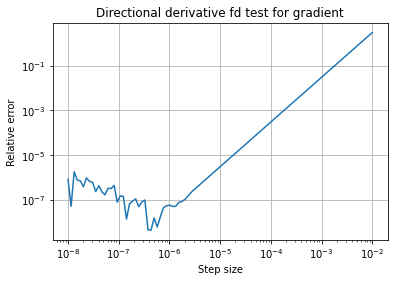

In [11]:
finite_diff.gradient_convergence_plot(pr, direction=direction)

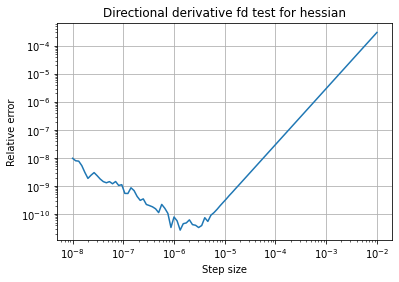

In [12]:
finite_diff.hessian_convergence_plot(pr, direction=direction)

<a id='sec:derivatives_blocks_ipc'></a>
## Test derivatives (IPC)

In [3]:
# Define rods
r = 1
rod_radius = 0.1
z_noise = 1e-2*r
twist = 1e-1
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
pr0 = define_periodic_circle(npts=6, material=material, r=r, z_noise=z_noise)
pr1 = define_periodic_circle(npts=10, material=material, r=r, translation=np.array([0.8*r, 0, 2*rod_radius]), z_noise=z_noise)
pr0.twist = twist
pr1.twist = twist
rod_list = elastic_knots.PeriodicRodsList([pr0, pr1])
# rod_list = elastic_knots.PeriodicRodsList([pr1])
npts = rod_list.numVertices()

In [3]:
# Define problem
initialContacts = []
contactOptions = elastic_knots.SlidingContactOptions()
contactOptions.dHat = 2.5*rod_radius
problemOptions = elastic_knots.SlidingProblemOptions()
problemOptions.contactType = elastic_knots.ContactType.IPC
problemOptions.minConstraintDistance = contactOptions.dHat

# problemOptions.flatConstrStiffness = 1e1
# # problemOptions.flatConstrAxis = 0
# flatConstrDir = np.random.rand(3)
# flatConstrDir /= np.linalg.norm(flatConstrDir)
# problemOptions.flatConstrDirection = flatConstrDir

problem = elastic_knots.SlidingProblem(rod_list, initialContacts, problemOptions, contactOptions)

softConstraints = [
    elastic_knots.FlatnessConstraint(stiffness=1, n=[1, 2, 3], center=[0.1, 0.3, 0.5], upper_d=0.2, lower_d=0.1),        # Test point out of lower bound
    elastic_knots.SphericalShellConstraint(stiffness=1, center=[0.1, 0.3, 0.5], upper_d=0.002, lower_d=0.001),
    elastic_knots.FlatnessConstraint(stiffness=1, n=[1, 2, 3], center=[0.1, 0.3, 0.5], upper_d=100.2, lower_d=100.1),    # Test point out of upper bound
    elastic_knots.SphericalShellConstraint(stiffness=1, center=[0.1, 0.3, 0.5], upper_d=100.2, lower_d=100.1),
    elastic_knots.VolumeConstraint(stiffness=1, aspectRatio=[1, 4, 7]),
]
problem.addSoftConstraints(softConstraints)

problem.updateConstraintSet()  # must be called if `contactType` is `IPC`

# Perturb dofs
# dofs = problem.getVars()
# firstModDofIdx = 50
# lastModDofIdx = 68
# maxDX = np.max(np.diff(boundingBox(rod_list), axis=0)[0])
# modDofs = dofs[firstModDofIdx:lastModDofIdx] + 1e-2*maxDX*np.random.rand(lastModDofIdx-firstModDofIdx)
# newDofs = np.hstack((dofs[0:firstModDofIdx], modDofs, dofs[lastModDofIdx::]))
# problem.setVars(newDofs)
# np.random.seed(0)
# problem.setVars(problem.getVars() + 1e-2*R*np.random.rand(problem.numVars()))
# rod_list.updateSourceFrame()

# Visualise rod
width, height = 640, 480
# view = Viewer(pr0, width=width, height=height)
viewBlockDeriv = Viewer(rod_list, width=width, height=height)
viewVectorsBlockDeriv = PointCloudViewer(boundingBox(rod_list), width=width, height=height, superView=viewBlockDeriv)
viewBlockDeriv.setCameraParams(((0.09155447828665847, -4.9286913312058065, 0.8364326268160376),
(-0.004680304182667601, 0.1672282372596419, 0.9859071008040222),
(0.0, 0.0, 0.0)))
viewBlockDeriv.show()

/home/mvidulis/miniconda3/envs/elastic_knots/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [4]:
problemOptions.contactType

<ContactType.IPC: 1>

In [5]:
pr0.hessianSparsityPattern().nz

240

In [6]:
pr0.hessian().nz

240

In [7]:
pr1.hessianSparsityPattern().nz

392

In [8]:
pr1.hessian().nz

392

In [9]:
rod_list.hessianSparsityPattern().nz

632

In [10]:
rod_list.hessian().nz

632

In [11]:
problem.hessianSparsityPattern().nz

740

In [12]:
problem.hessian()

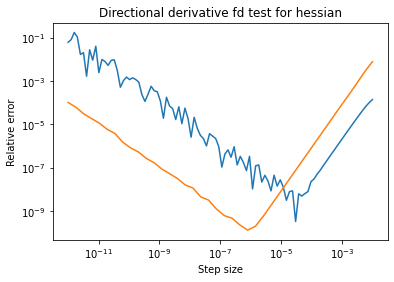

In [4]:
# Test derivatives in random direction
seed = 0
np.random.seed(seed)
direction = np.random.uniform(-1, 1, problem.numVars())
# v = problem.numVars()-1; direction = np.zeros(problem.numVars()); direction[v] = 1.0;  # test single component
finite_diff.gradient_convergence_plot(problem, direction=direction)
finite_diff.hessian_convergence_plot(problem, direction=direction)

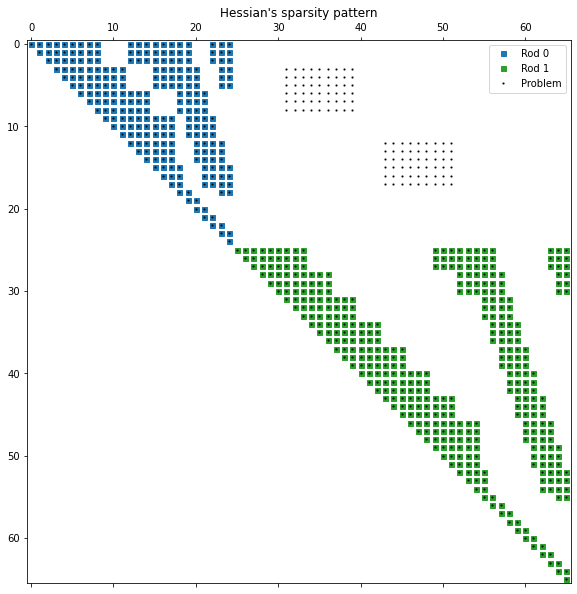

In [5]:
# Hessian sparsity pattern
hessianRod0 = pr0.hessianSparsityPattern(1.0).toSciPy()
hessianRod1 = pr1.hessianSparsityPattern(1.0).toSciPy()
# hessianContact = contact.hessianSparsityPattern(1.0).toSciPy()
hessianProblem = problem.hessianSparsityPattern().toSciPy()  # problem's hessian
hessianProblem.data[:] = 1  # fill with ones

# South-East shift rod 1
from scipy.sparse import csr_matrix
nv = problem.numVars()
mat = np.zeros((nv, nv))
upperLeft = rod_list.firstGlobalDofIndexInRod(1)
lowerRight = upperLeft + rod_list.numDoFInRod(1)
mat[upperLeft:lowerRight, upperLeft:lowerRight] = hessianRod1.todense()
hessianRod1 = csr_matrix(mat)

fig, ax = plt.subplots(figsize=(10, 10))
ax.spy(hessianRod0,    **{'c': 'C0',  'ms': 5, 'label': 'Rod 0'})
ax.spy(hessianRod1,    **{'c': 'C2',  'ms': 5, 'label': 'Rod 1'})
# ax.spy(hessianContact, **{'c': 'red', 'ms': 3, 'label': 'Contact'})
ax.spy(hessianProblem, **{'c': 'k',   'ms': 1, 'label': 'Problem'})
ax.legend()
ax.set_title('Hessian\'s sparsity pattern')

plt.show()

In [16]:
# from elastic_rods import EnergyType

# def hessian_convergence_block_plot(problem, var_types, var_indices, etype=EnergyType.Full):
#     """
#     Adapted from finite_diff, modified to support problem object with additional material variables.
#     """
#     grad = problem.gradient()
#     perturb = np.random.normal(0, 1, len(grad))
#     numVarTypes = len(var_types) - 1
#     epsilons = np.logspace(np.log10(1e-12), np.log10(1e-2), 50)
#     fig = plt.figure(figsize=(16, 12))
#     for i, vi in enumerate(var_types[1:]):
#         for j, vj in enumerate(var_types[1:]):
#             plt.subplot(numVarTypes, numVarTypes, i * numVarTypes + j + 1)
#             errors = [finite_diff.block_error(
#                 problem, var_indices, vi, vj, grad, etype, eps, perturb, 
#                 variableDesignParameters=False, perSegmentRestLen=False, hessianVectorProduct=False
#             )[0] for eps in epsilons]
#             plt.loglog(epsilons, errors)
#             plt.title(f'({vi}, {vj}) block')
#             plt.grid()
#             plt.tight_layout()
# #     plt.savefig(plot_name, dpi = 300)
#     plt.show()
    

# first = 9
# last = 12

# var_types = ['FULL', 'block']
# var_indices = {'FULL': range(0, rod_list[0].numDoF()),
#                'block': range(first, last+1),
# }
# hessian_convergence_block_plot(problem, var_types, var_indices)

Test `ipc-toolkit` bindings

In [ ]:
# sys.path.append('../3rdparty/ipc-toolkit/build/lib.linux-x86_64-3.8')
# import ipctk

In [ ]:
# cs = problem.constraintSet

In [ ]:
# cs.size()

In [ ]:
# cs.ee_constraints

<a id='sec:derivatives_blocks_sliding'></a>
## Test derivatives (sliding contacts)

In [ ]:
# Define rod
R = 1
rod_radius = 0.1
z_noise = 1e-5*R
twist = 1e-1
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
pr0 = define_periodic_circle(npts=6, material=material, R=R, z_noise=z_noise)
pr1 = define_periodic_circle(npts=10, material=material, R=R, trans=np.array([0.8*R, 0, 2*rod_radius]), z_noise=z_noise)
pr0.twist = twist
pr1.twist = twist
rod_list = elastic_knots.PeriodicRodsList([pr0, pr1])
npts = rod_list.numVertices()

In [ ]:
# Define contact
contactOptions = elastic_knots.SlidingContactOptions()
contactOptions.stiffness = 1e5
contactOptions.stiffTang = 1e5
contactOptions.eps = 1e-1
contactOptions.energyType = elastic_knots.ContactEnergyType.IPCBarrier
contactOptions.dHat = 3*rod_radius  # make sure the barrier is active in the configuration we are testing
contactOptions.xi = 1e-7
matVars = [4.8*R, 3.8*R]
rodsIndices = [0, 1]
contact = elastic_knots.SlidingContact(rod_list, rodsIndices, matVars, contactOptions)

# Define problem
initialContacts = [contact]
problemOptions = elastic_knots.SlidingProblemOptions()
problemOptions.contactType = elastic_knots.ContactType.Sliding
problem = elastic_knots.SlidingProblem(rod_list, initialContacts, problemOptions, contactOptions)

# problem.updateConstraintSet()  # must be called if `contactType` is `IPC`

# Perturb dofs
# dofs = problem.getVars()
# firstModDofIdx = 50
# lastModDofIdx = 68
# maxDX = np.max(np.diff(boundingBox(rod_list), axis=0)[0])
# modDofs = dofs[firstModDofIdx:lastModDofIdx] + 1e-2*maxDX*np.random.rand(lastModDofIdx-firstModDofIdx)
# newDofs = np.hstack((dofs[0:firstModDofIdx], modDofs, dofs[lastModDofIdx::]))
# problem.setVars(newDofs)
# np.random.seed(0)
# problem.setVars(problem.getVars() + 1e-2*R*np.random.rand(problem.numVars()))
# rod_list.updateSourceFrame()

# Visualise rod
width, height = 640, 480
# view = Viewer(pr0, width=width, height=height)
viewBlockDeriv = Viewer(rod_list, width=width, height=height)
viewVectorsBlockDeriv = PointCloudViewer(boundingBox(rod_list), width=width, height=height, superView=viewBlockDeriv)
viewBlockDeriv.setCameraParams(((0.09155447828665847, -4.9286913312058065, 0.8364326268160376),
(-0.004680304182667601, 0.1672282372596419, 0.9859071008040222),
(0.0, 0.0, 0.0)))
viewBlockDeriv.show()

In [ ]:
# Visualise contact
contactEdges = np.zeros((npts + rod_list.numRods(),))
for i in range(rod_list.numRods()):
    contactEdges[rod_list.firstGlobalEdgeIndexInRod(i)] = 1.0  # first edges are red
    contactEdges[rod_list.firstGlobalEdgeIndexInRod(i)] = 1.0  # last ones (overlapped, only for visualization) are red, too
contactEdges[contact.contactIdx(0)] = .75             # over contact edge is orange
contactEdges[contact.contactIdx(1)] = .25             # over contact edge is cyan
contactEdges = periodic_scalar_field(contactEdges, rod_list)
viewBlockDeriv.update(mesh=rod_list, preserveExisting=False, scalarField=contactEdges)

# Visualise normal
vectorPoints = contact.slidingNode(0).reshape((-1, 3))
vectors = contact.unitaryContactNormal().reshape((-1, 3))
# vectors = np.append(vectors, np.array([0, 0, 2]).reshape((-1, 3)), axis=0)  # add red arrow to origin, contact normal is scaled to green
# vectorPoints = np.append(vectorPoints, np.array([0, 0, 0]).reshape((-1, 3)), axis=0)
viewVectorsBlockDeriv.update(mesh=PointCloudMesh(vectorPoints), vectorField=vectors)

In [ ]:
# DoF indices
im3, i, ip3, ip6 = contact.stencilDofs(0)
jm3, j, jp3, jp6 = contact.stencilDofs(1)
ndofs = problem.numVars()
u = ndofs - 2
v = ndofs - 1

In [ ]:
# Test derivatives in random direction
seed = 0
np.random.seed(seed)
direction = np.random.uniform(-1, 1, problem.numVars())
direction = np.zeros(problem.numVars()); direction[v] = 1.0;  # test single component
finite_diff.gradient_convergence_plot(problem, direction=direction)
finite_diff.hessian_convergence_plot(problem, direction=direction)

In [ ]:
# Hessian sparsity pattern
hessianRod0 = pr0.hessianSparsityPattern(1.0).toSciPy()
hessianRod1 = pr1.hessianSparsityPattern(1.0).toSciPy()
hessianContact = contact.hessianSparsityPattern(1.0).toSciPy()
hessianProblem = problem.hessianSparsityPattern().toSciPy()  # problem's hessian
hessianProblem.data[:] = 1  # fill with ones

# South-East shift rod 1
from scipy.sparse import csr_matrix
nv = problem.numVars()
mat = np.zeros((nv, nv))
upperLeft = rod_list.firstGlobalDofIndexInRod(1)
lowerRight = upperLeft + rod_list.numDoFInRod(1)
mat[upperLeft:lowerRight, upperLeft:lowerRight] = hessianRod1.todense()
hessianRod1 = csr_matrix(mat)

fig, ax = plt.subplots(figsize=(10, 10))
ax.spy(hessianRod0,    **{'c': 'C0',  'ms': 5, 'label': 'Rod 0'})
ax.spy(hessianRod1,    **{'c': 'C2',  'ms': 5, 'label': 'Rod 1'})
ax.spy(hessianContact, **{'c': 'red', 'ms': 3, 'label': 'Contact'})
# ax.spy(hessianProblem, **{'c': 'k',   'ms': 1, 'label': 'Problem'})
ax.legend()
ax.set_title('Hessian\'s sparsity pattern')

plt.show()

In [ ]:
from elastic_rods import EnergyType

def hessian_convergence_block_plot(problem, var_types, var_indices, etype=EnergyType.Full):
    """
    Adapted from finite_diff, modified to support problem object with additional material variables.
    """
    grad = problem.gradient()
    perturb = np.random.normal(0, 1, len(grad))
    numVarTypes = len(var_types) - 1
    epsilons = np.logspace(np.log10(1e-12), np.log10(1e-2), 50)
    fig = plt.figure(figsize=(16, 12))
    for i, vi in enumerate(var_types[1:]):
        for j, vj in enumerate(var_types[1:]):
            plt.subplot(numVarTypes, numVarTypes, i * numVarTypes + j + 1)
            errors = [finite_diff.block_error(
                problem, var_indices, vi, vj, grad, etype, eps, perturb, 
                variableDesignParameters=False, perSegmentRestLen=False, hessianVectorProduct=False
            )[0] for eps in epsilons]
            plt.loglog(epsilons, errors)
            plt.title(f'({vi}, {vj}) block')
            plt.grid()
            plt.tight_layout()
#     plt.savefig(plot_name, dpi = 300)
    plt.show()

In [ ]:
var_types = ['FULL', 'i-3', 'i', 'i+3', 'i+6', 'j-3', 'j', 'j+3', 'j+6', 'u', 'v']
var_indices = {'FULL': range(0, rod_list[0].numDoF()),
               'i-3': range(im3, im3+3),
               'i'  : range(i,   i  +3),
               'i+3': range(ip3, ip3+3),
               'i+6': range(ip6, ip6+3),
               'j-3': range(jm3, jm3+3),
               'j'  : range(j,   j  +3),
               'j+3': range(jp3, jp3+3),
               'j+6': range(jp6, jp6+3),
               'u':   range(u,   u+1),
               'v':   range(v,   v+1)}
hessian_convergence_block_plot(problem, var_types, var_indices)

In [ ]:
var_types = ['FULL', 'i-3', 'i', 'j-3', 'j']
var_indices = {'FULL': range(0, rod_list[0].numDoF()),
               'i-3': range(im3, im3+3),
               'i'  : range(i,   i  +3),
#                'i+3': range(ip3, ip3+3),
#                'i+6': range(ip6, ip6+3),
               'j-3': range(jm3, jm3+3),
               'j'  : range(j,   j  +3),
#                'j+3': range(jp3, jp3+3),
#                'j+6': range(jp6, jp6+3),
               }
hessian_convergence_block_plot(problem, var_types, var_indices)

In [ ]:
var_types = ['FULL', 'i-3', 'i', 'i+3', 'i+6', 'j-3', 'j', 'j+3', 'j+6']
var_indices = {'FULL': range(0, rod_list[0].numDoF()),
               'i-3': range(im3, im3+3),
               'i'  : range(i,   i  +3),
               'i+3': range(ip3, ip3+3),
               'i+6': range(ip6, ip6+3),
               'j-3': range(jm3, jm3+3),
               'j'  : range(j,   j  +3),
               'j+3': range(jp3, jp3+3),
               'j+6': range(jp6, jp6+3),
               }
hessian_convergence_block_plot(problem, var_types, var_indices)

In [ ]:
var_types = ['FULL', 'j-3', 'j', 'j+3', 'j+6'] #, 'u', 'v']
var_indices = {'FULL': range(0, rod_list[0].numDoF()),
               'j-3': range(jm3, jm3+3),
               'j'  : range(j,   j  +3),
               'j+3': range(jp3, jp3+3),
               'j+6': range(jp6, jp6+3),
#                'u':   range(u,   u+1),
#                'v':   range(v,   v+1)
}
hessian_convergence_block_plot(problem, var_types, var_indices)

In [ ]:
var_types = ['FULL', 'i-3', 'i', 'i+3', 'i+6'] #, 'u', 'v']
var_indices = {'FULL': range(0, rod_list[0].numDoF()),
               'i-3': range(im3, im3+3),
               'i'  : range(i,   i  +3),
               'i+3': range(ip3, ip3+3),
               'i+6': range(ip6, ip6+3),
#                'u':   range(u,   u+1),
#                'v':   range(v,   v+1)
              }
hessian_convergence_block_plot(problem, var_types, var_indices)

In [ ]:
var_types = ['FULL', 'u', 'v']
var_indices = {'FULL': range(0, rod_list[0].numDoF()),
               'u':   range(u,   u+1),
               'v':   range(v,   v+1)
}
hessian_convergence_block_plot(problem, var_types, var_indices)

<a id='sec:derivatives_connection'></a>
## Test derivatives when contact is close to the connection (sliding contacts)
Initialize one of the sliding nodes approximately at the connection to check for eventual discontinuities

In [50]:
R = 1
rod_radius = 0.01
npts0 = 40
npts1 = 30
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
pr0 = define_periodic_circle(npts=npts0, material=material, R=R)
pr1 = define_periodic_circle(npts=npts1, material=material, R=R, trans=np.array([2*R+rod_radius, 0, 2*rod_radius]))
rod_list = elastic_knots.PeriodicRodsList([pr0, pr1])
npts = rod_list.numVertices()

In [51]:
# # Choose contact edges
# edge0 = npts0-1 # 38
# edge1 = 55 # 40

# # Define contact
# contactOptions = elastic_knots.SlidingContactOptions()
# contactOptions.stiffness = 1e5
# contactOptions.eps = 1e-1
# rodsIndices = [rod_list.rodIndexFromGlobalEdgeIndex(edge0), rod_list.rodIndexFromGlobalEdgeIndex(edge1)]
# matVars = compute_material_vars([edge0, edge1], rod_list)
# dh = 1e-5
# matVars[0] = np.cumsum(pr0.rod.restLengths())[-2] - dh  # move first sliding node very close to the connection
# contact = elastic_knots.SlidingContact(rod_list, rodsIndices, matVars, contactOptions)

In [52]:
# Choose contact edges
edge0 = npts0-1 # 38
edge1 = 55 # 40

# Define contact
contactOptions = elastic_knots.SlidingContactOptions()
contactOptions.stiffness = 1e5
contactOptions.eps = 1e-1
rodsIndices = [rod_list.rodIndexFromGlobalEdgeIndex(edge0), rod_list.rodIndexFromGlobalEdgeIndex(edge1)]
matVars = compute_material_vars([edge0, edge1], rod_list)
dh = 1e-5
matVars[0] = np.cumsum(pr0.rod.restLengths())[-2] - dh  # move first sliding node very close to the connection
contact = elastic_knots.SlidingContact(rod_list, rodsIndices, matVars, contactOptions)

# Define problem
initialContacts = [contact]
problemOptions = elastic_knots.SlidingProblemOptions()
problemOptions.contactType = elastic_knots.ContactType.Sliding
problem = elastic_knots.SlidingProblem(rod_list, initialContacts, problemOptions, contactOptions)

# Visualise rod
width, height = 640, 480
# view = Viewer(pr0, width=width, height=height)
viewContacts2 = Viewer(rod_list, width=width, height=height)
viewVectorsContacts2 = PointCloudViewer(boundingBox(rod_list), width=width, height=height, superView=viewContacts2)
viewContacts2.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [47]:
print("Contact edge: " + str(edge0) + ", Catmull-Rom stencil: " + str(contact.stencilNodes(0)))
print("Contact edge: " + str(edge1) + ", Catmull-Rom stencil: " + str(contact.stencilNodes(1)))

Contact edge: 39, Catmull-Rom stencil: [38, 39, 0, 1]
Contact edge: 55, Catmull-Rom stencil: [54, 55, 56, 57]


In [48]:
# Visualise contact
contactEdges = np.zeros((npts + rod_list.numRods(),))
contactEdges[[0, npts0]] = 1.0                        # first edges are red
contactEdges[contact.contactIdx(0)] = .75             # over contact edge is orange
contactEdges[contact.contactIdx(1)] = .25             # over contact edge is cyan
extendedContactEdges = periodic_scalar_field(contactEdges, rod_list)
viewContacts2.update(mesh=rod_list, preserveExisting=False, scalarField=extendedContactEdges)

# Visualise normal
vectorPoints = contact.slidingNode(0).reshape((-1, 3))
vectors = contact.unitaryContactNormal().reshape((-1, 3))
# vectors = np.append(vectors, np.array([0, 0, 2]).reshape((-1, 3)), axis=0)  # add red arrow to origin, contact normal is scaled to green
# vectorPoints = np.append(vectorPoints, np.array([0, 0, 0]).reshape((-1, 3)), axis=0)
viewVectorsContacts2.update(mesh=PointCloudMesh(vectorPoints), vectorField=vectors)

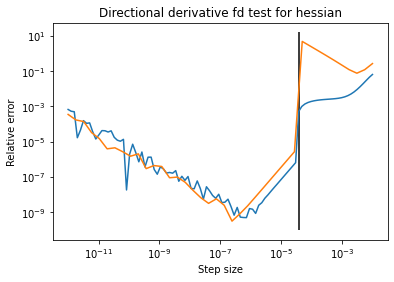

In [49]:
np.random.seed(1)
direction = np.random.uniform(-1, 1, problem.numVars())
finite_diff.gradient_convergence_plot(problem, direction=direction)
finite_diff.hessian_convergence_plot(problem, direction=direction)
plt.vlines(4*dh, *plt.gca().get_ylim(), color='k')
plt.show()

<a id='sec:projection'></a>
# Test $\epsilon$-projection

In [41]:
width, height = 640, 480
# view = Viewer(pr0, width=width, height=height)
viewProj = Viewer(rod_list, width=width, height=height)
viewVectorsProj = PointCloudViewer(boundingBox(rod_list), width=width, height=height, superView=viewProj)
# viewProj.setCameraParams(((0.09155447828665847, -4.9286913312058065, 0.8364326268160376),
# (-0.004680304182667601, 0.1672282372596419, 0.9859071008040222),
# (0.0, 0.0, 0.0)))
viewProj.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [42]:
# Visualise contact
contactEdges = np.zeros((npts + rod_list.numRods(),))
for i in range(rod_list.numRods()):
    contactEdges[rod_list.firstGlobalEdgeIndexInRod(i)] = 1.0  # first edges are red
    contactEdges[rod_list.firstGlobalEdgeIndexInRod(i)] = 1.0  # last ones (overlapped, only for visualization) are red, too
contactEdges[contact.contactIdx(0)] = .75             # over contact edge is orange
contactEdges[contact.contactIdx(1)] = .25             # over contact edge is cyan
contactEdges = periodic_scalar_field(contactEdges, rod_list)
viewProj.update(mesh=rod_list, preserveExisting=False, scalarField=contactEdges)

# Visualise normal
vectorPoints = contact.slidingNode(0).reshape((-1, 3))
vectors = contact.unitaryContactNormal().reshape((-1, 3))
# vectors = np.append(vectors, np.array([0, 0, 2]).reshape((-1, 3)), axis=0)  # add red arrow to origin, contact normal is scaled to green
# vectorPoints = np.append(vectorPoints, np.array([0, 0, 0]).reshape((-1, 3)), axis=0)
viewVectorsProj.update(mesh=PointCloudMesh(vectorPoints), vectorField=vectors)

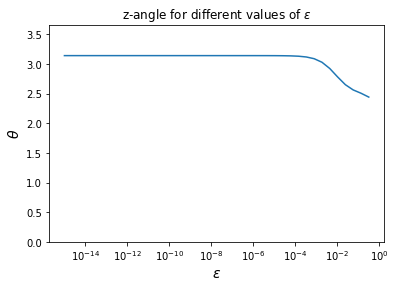

In [45]:
# Effect of epsilon on the contact normal
nSamples = 40
zAngle = np.zeros(nSamples)
epsilon = np.logspace(-.5, -15, nSamples)
for i, eps in enumerate(epsilon):
    # Change epsilon in normal definition
    contactOptions.eps = eps
    contact = elastic_knots.SlidingContact(rod_list, rodsIndices, matVars, contactOptions)
    initialContacts = [contact]
    problem = elastic_knots.SlidingProblem(rod_list, [contact], problemOptions, contactOptions)
    zAngle[i] = np.arccos(contact.unitaryContactNormal()[2])

fig, ax = plt.subplots()
ax.semilogx(epsilon, zAngle)
ax.set_xlabel('$\epsilon$', fontsize=14)
ax.set_ylabel(r'$\theta$', fontsize=14)
ax.set_ylim([0, np.pi+np.pi/6])
ax.set_title('z-angle for different values of $\epsilon$')
plt.show()

In [61]:
# Explicit computation of the epsilon-projection

def P(v, eps=0):
    v = v.reshape((-1, 1))
    return v @ v.T / (np.linalg.norm(v)**2 + eps)

eps = 1e-9
# v = np.array([1.0, 1.0, -1.0])
v = contact.slidingNodeOver() - contact.slidingNodeUnder()
ta = contact.unitaryTangent(0)
tb = contact.unitaryTangent(1)
w1 = ta + tb
w2 = ta - tb
Pw1 = P(w1, eps)
Pw2 = P(w2, eps)
n = (np.eye(3) - Pw1 - Pw2) @ v
print("ta x tb: ", np.cross(ta, tb))
print("w1:      ", w1)
print("w2:      ", w2)
print("Proj w1: ", Pw1 @ v)
print("Proj w2: ", Pw2 @ v)
print("Normal:  ", n)

vectorPoints = contact.slidingNode(0).reshape((-1, 3))
vectorPoints = np.vstack((contact.slidingNode(0).reshape((-1, 3)), vectorPoints))
vectorPoints = np.vstack((contact.slidingNode(0).reshape((-1, 3)), vectorPoints))
# vectorPoints = np.vstack((contact.slidingNode(0).reshape((-1, 3)), vectorPoints))
vectors = n / np.linalg.norm(n) / 1.4
vectors = np.vstack((w1 / np.linalg.norm(w1) / 2, vectors))
vectors = np.vstack((w2 / np.linalg.norm(w2) / 2, vectors))
# vectors = np.vstack((contact.unitaryContactNormal().reshape((-1, 3)), vectors))
viewVectorsProj.update(mesh=PointCloudMesh(vectorPoints), vectorField=vectors)
viewProj.update(mesh=rod_list, preserveExisting=False, scalarField=contactEdges)

ta x tb:  [-1.725292e-17 4.457860e-20 -1.070978e-01]
w1:       [1.071123e-01 5.474767e-03 -1.725298e-17]
w2:       [-1.019446e-01 1.994519e+00 1.725298e-17]
Proj w1:  [-1.362420e-02 -6.963658e-04 2.194502e-18]
Proj w2:  [-6.877266e-03 1.345518e-01 1.163900e-18]
Normal:   [-1.186127e-09 -2.680273e-11 -2.000000e-02]


<a id='sec:cr_interp'></a>
# Test Catmull-Rom interpolation

### Catmull-Rom from Wikipedia

In [58]:
import numpy
import matplotlib.pyplot as plt

def CatmullRomSpline(P0, P1, P2, P3, nPoints=5):
    """
    P0, P1, P2, and P3 should be (x,y) point pairs that define the Catmull-Rom spline.
    nPoints is the number of points to include in this curve segment.
    """
    # Convert the points to numpy so that we can do array multiplication
    P0, P1, P2, P3 = map(numpy.array, [P0, P1, P2, P3])

    # Parametric constant: 0.5 for the centripetal spline, 0.0 for the uniform spline, 1.0 for the chordal spline.
    alpha = 1.0
    # Premultiplied power constant for the following tj() function.
    alpha = alpha/2
    def tj(ti, Pi, Pj):
        xi, yi = Pi
        xj, yj = Pj
        return ((xj-xi)**2 + (yj-yi)**2)**alpha + ti

    # Calculate t0 to t4
    t0 = 0
    t1 = tj(t0, P0, P1)
    t2 = tj(t1, P1, P2)
    t3 = tj(t2, P2, P3)

    # Only calculate points between P1 and P2
    t = numpy.linspace(t1, t2, nPoints)

    # Reshape so that we can multiply by the points P0 to P3
    # and get a point for each value of t.
    t = t.reshape(len(t), 1)
#     print(t)
    A1 = (t1-t)/(t1-t0)*P0 + (t-t0)/(t1-t0)*P1
    A2 = (t2-t)/(t2-t1)*P1 + (t-t1)/(t2-t1)*P2
    A3 = (t3-t)/(t3-t2)*P2 + (t-t2)/(t3-t2)*P3
    B1 = (t2-t)/(t2-t0)*A1 + (t-t0)/(t2-t0)*A2
    B2 = (t3-t)/(t3-t1)*A2 + (t-t1)/(t3-t1)*A3

    C = (t2-t)/(t2-t1)*B1 + (t-t1)/(t2-t1)*B2
#     print(A1[0], A2[0], A3[0], B1[0], B2[0], C[0])
    return C


def CatmullRomChain(P):
    """
    Calculate Catmull-Rom for a chain of points and return the combined curve.
    """
    sz = len(P)

    # The curve C will contain an array of (x, y) points.
    C = []
    nPointsPerSection = 5
    for i in range(sz-3):
        c = CatmullRomSpline(P[i], P[i+1], P[i+2], P[i+3], nPoints=nPointsPerSection)
        if len(C) > 0 and np.linalg.norm(C[-1] - c[0]) < 1e-10:
            c = c[1::]
        C.extend(c)
    return C

### Check Catmull-Rom interpolation at the connection

In [59]:
R = 1
rod_radius = 0.01
npts0 = 40
npts1 = 30
np.random.seed(1)
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
noise = 3e-2
pr0 = define_periodic_circle(npts=npts0, material=material, R=R, xNoise=noise, yNoise=noise)
pr1 = define_periodic_circle(npts=npts1, material=material, R=R, trans=np.array([2*R+rod_radius, 0, 2*rod_radius]))
rod_list = elastic_knots.PeriodicRodsList([pr0, pr1])
npts = rod_list.numVertices()

# Choose contact edges
edge0 = npts0-1
edge1 = 55

# Define contact
contactOptions = elastic_knots.SlidingContactOptions()
contactOptions.stiffness = 1e5
contactOptions.eps = 1e-1
rodsIndices = [rod_list.rodIndexFromGlobalEdgeIndex(edge0), rod_list.rodIndexFromGlobalEdgeIndex(edge1)]
matVars = compute_material_vars([edge0, edge1], rod_list)
# matVars[0] = np.cumsum(pr0.rod.restLengths())[-2] - 1e-5  # move first sliding node very close to the connection
contact = elastic_knots.SlidingContact(rod_list, rodsIndices, matVars, contactOptions)

Max error:  6.661338147750939e-16


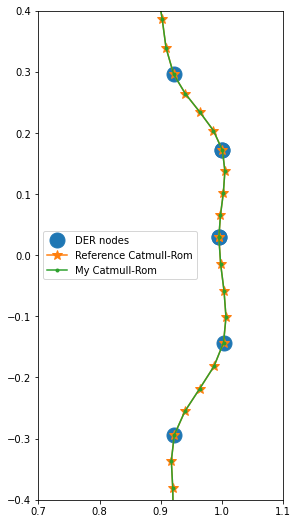

In [60]:
dp = np.array(pr0.rod.deformedPoints())

# C-R from Wikipedia
Points = np.vstack((dp[-3, :], dp[:, :]))
referenceCR = CatmullRomChain(Points[:, 0:2])
x, y = zip(*referenceCR)

# My C-R
nPtsCR = len(referenceCR)
nv = pr0.numVertices()
ne = nv
nPointsPerSection = int((nPtsCR - 1) / nv + 1)
# Lrod = np.cumsum(pr0.rod.restLengths())[-2]
refMatVars = np.append(0, np.cumsum(pr0.rod.restLengths()))
pointsCR = []
stencilNodes = []
for ei in range(ne):
    for u in np.linspace(refMatVars[ei], refMatVars[ei+1], nPointsPerSection):
        matVars = [u, contact.materialVar(1)]
        contact.setMaterialVars(matVars)
        point = contact.slidingNode(0)
        if (len(pointsCR) > 0 and np.linalg.norm(point - pointsCR[-1]) > 1e-10) or len(pointsCR) == 0:  # exclude duplicated nodes
            pointsCR.append(point)
            stencilNodes.append(contact.stencilNodes(0))
pointsCR = np.array(pointsCR)[:, 0:2]

print("Max error: ", np.max(np.abs(pointsCR - referenceCR)))

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(dp[:, 0], dp[:, 1], marker='.', markersize=30, linestyle='', label='DER nodes')
ax.plot(x, y, marker='*', markersize=10, label='Reference Catmull-Rom')
ax.plot(pointsCR[:, 0], pointsCR[:, 1], marker='.', label='My Catmull-Rom')
ax.set_aspect('equal')
ax.set_xlim([0.7, 1.1])
ax.set_ylim([-0.4, 0.4])
ax.legend()
plt.show()

<a id='sec:visualisation'></a>
# Test visualisation

In [ ]:
R = 1
rod_radius = 0.01
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
pr0 = define_periodic_circle(npts=4, material=material, R=R)
pr1 = define_periodic_circle(npts=3, material=material, R=R, trans=np.array([0.5, 0, 2*rod_radius]))
rod_list = elastic_knots.PeriodicRodsList([pr0, pr1])

width, height = 640, 480
v = linkage_vis.LinkageViewer(rod_list, width, height)
v.show()

In [ ]:
# Test visualisation
perEdgeScalarField = np.array([0, 1, 2, 3, 0, 6, 7, 8, 6])
v.update(mesh=rod_list, preserveExisting=False, scalarField=perEdgeScalarField)
time.sleep(1)

perNodeScalarField = np.array([0, 1, 2, 3, 0, 1, 6, 7, 8, 6, 7])
v.update(mesh=rod_list, preserveExisting=False, scalarField=perNodeScalarField)
time.sleep(1)

perEdgeVectorField = np.array([
    [
        [0,  1, 0],
        [0,  1, 0],
        [0,  1, 0],
        [0,  1, 0],
        [0,  1, 0],
    ],
    [
        [0,  2, 0],
        [0,  2, 0],
        [0,  2, 0],
        [0,  3, 0],
    ]
], dtype=object)
v.update(mesh=rod_list, preserveExisting=False, vectorField=perEdgeVectorField)
time.sleep(1)

perNodeVectorField = np.array([
    [
        [0, 0, 11],
        [0, 0, 12],
        [0, 0, 13],
        [0, 0, 14],
        [0, 0, 15],
        [0, 0, 16],
    ],
    [
        [0,  11, 0],
        [0,  12, 0],
        [0,  13, 0],
        [0,  14, 0],
        [0,  15, 0],
    ]
], dtype=object)
v.update(mesh=rod_list, preserveExisting=False, vectorField=perNodeVectorField)
time.sleep(1)

<a id='sec:optimization'></a>

# Test optimization

In [53]:
from helpers_knots import figureEight, generate_curve
%run ./"helpers_optimization.ipynb"

In [54]:
# Parametric knot
twist = 0 * np.pi # 8*np.pi, 0*np.pi
rod_radius = .5 # 0.1
r = 5
npts = 100
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])

parametricCurve = figureEight(r)
deformedConfig = generate_curve(parametricCurve, npts, 0, 2*np.pi)
pr = define_periodic_rod(deformedConfig, material, twist=twist)

rod_list = elastic_knots.PeriodicRodsList([pr])

# View
# width, height = 640, 480
width, height = 1024, 640
# width, height = 1536, 960
view = Viewer(rod_list, width=width, height=height)
viewVectors = PointCloudViewer(boundingBox(rod_list), width=width, height=height, superView=view)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [55]:
optimizerOptions, problemOptions, contactOptions = default_options()
# activeContacts = []
fixedVars = [rod_list[0].numDoF()-1, rod_list[0].thetaOffset(), 0, 1, 2, 3, 4, 5]
# fixedVars = []

# Optimize
report = elastic_knots.compute_equilibrium(
    rod_list, problemOptions, contactOptions, optimizerOptions, 
    fixedVars=fixedVars,
    externalForces=np.zeros(rod_list.numDoF()),
    initialContacts=[],
    callback=callback_multi_rods_with_contacts
)

Armijo condition satisfied.   0	121.491	17.8469	17.8469	0.5	1
Armijo condition satisfied.   1	109.101	36.4567	36.4567	1	0
Armijo condition satisfied.   2	96.6818	14.1846	14.1846	0.5	0
Armijo condition satisfied.   3	93.0375	18.1484	18.1484	1	0
Armijo condition satisfied.   4	89.0182	9.99739	9.99739	0.484079	0
Armijo condition satisfied.   5	87.5663	10.0015	10.0015	0.980306	0
Armijo condition satisfied.   6	181.096	131184	131184	1	1
Tau running away
||H||_2: -5.21858e+13
||M||_2: 1
Scaled tau: -1.661e+94
7	181.011	1.52807e+06	1.52807e+06	1	1


---
# Test Julian's `PeriodicRod`

### Finite Difference Validation

In [ ]:
import fd_validation

class FDWrapper:
    def __init__(self, rod):
        self.rod = rod
    def numVars(self): return self.rod.numDoF()
    def getVars(self): return self.rod.getDoFs()
    def setVars(self, x): return self.rod.setDoFs(x)
    def energy(self): return self.rod.energy()
    def gradient(self): return self.rod.gradient(updatedSource=False)
    def hessian(self): return self.rod.hessian()

In [ ]:
pr.setDoFs(pr.getDoFs() + 1e-3 * fd_validation.genPerturbation(pr.getDoFs()))
pr.rod.updateSourceFrame()

In [ ]:
fd_validation.gradConvergencePlot(FDWrapper(pr))

In [ ]:
fd_validation.hessConvergencePlot(FDWrapper(pr.rod))

In [ ]:
wpr = FDWrapper(pr)
fd_validation.hessConvergencePlot(wpr, perturb=fd_validation.basisDirection(wpr, 0))

### Twist

In [ ]:
import sys
import sys; sys.path.append('../3rdparty/elastic_rods/python'); sys.path.append('../3rdparty/elastic_rods/3rdparty/MeshFEM/python')
import elastic_rods
import numpy as np
from typing import NamedTuple
from bending_validation import suppress_stdout as so

In [ ]:
npts = 200

In [ ]:
t = np.linspace(0, 2 * np.pi, npts-2, endpoint=False)
t = np.concatenate([t, t[0:2]])

In [ ]:
R = 40
pts = np.column_stack([R * np.cos(t), R * np.sin(t), np.zeros_like(t)])

In [ ]:
pr = elastic_rods.PeriodicRod(pts, True)
# pr.setMaterial(elastic_rods.RodMaterial('rectangle', 4.0e10 / 1e6, 0.3, [1, 1], stiffAxis=elastic_rods.StiffAxis.D2))
pr.setMaterial(elastic_rods.RodMaterial('ellipse',   4.0e10 / 1e6, 0.3, [1, 1]))

In [ ]:
dc = pr.rod.deformedConfiguration()

In [ ]:
Hsp = pr.hessianSparsityPattern(1.0)

In [ ]:
import linkage_vis, vis
import matplotlib

In [ ]:
import time
def updateView():
    v.update()
#     time.sleep(0.01)
    cv2.update(vectorField=np.array([d.d2 for d in dc.materialFrame]))
    refVF = vis.fields.VectorField(cv.mesh, np.array([d.d2 for d in dc.referenceDirectors]), colormap=matplotlib.cm.cool_r, glyph=vis.fields.VectorGlyph.CYLINDER)
    cv.update(vectorField=refVF)

In [ ]:
# width, height = 1024, 640
width, height = 640, 480
v = linkage_vis.LinkageViewer(pr, width, height)
cv = linkage_vis.CenterlineViewer(pr.rod, superView=v, vectorField=np.array([d.d2 for d in dc.referenceDirectors]))
cv2 = linkage_vis.CenterlineViewer(pr.rod, superView=v, vectorField=np.array([d.d2 for d in dc.materialFrame]))
v.show()

In [ ]:
# pr.twist = 8 * np.pi
# elastic_rods.compute_equilibrium(pr, fixedVars=[pr.numDoF()-1, pr.thetaOffset(), 0, 1, 2, 3, 4, 5], callback=custom_callback)

In [ ]:
pr.twist = 8 * np.pi
# time.sleep(8)

def custom_callback(prob, i):
#     time.sleep(1)
    updateView()
    
with so(): elastic_rods.compute_equilibrium(pr, fixedVars=[pr.numDoF()-1, pr.thetaOffset(), 0, 1, 2, 3, 4, 5], callback=custom_callback)

# Test `ElasticRod` with collision detection
(Not working, needs old interface for `ElasticRod`)

In [ ]:
rod_radius = 1
rodTwist = 8 * np.pi
material = elastic_rods.RodMaterial('ellipse', 2e3, 0.3, [rod_radius, rod_radius])
# material = elastic_rods.RodMaterial('rectangle', 4.0e10 / 1e6, 0.3, [1, 1], stiffAxis=elastic_rods.StiffAxis.D2)
npts = nv = 200
ne = nv - 1
R = 40

t = np.linspace(0, 2 * np.pi, npts-3, endpoint=False)
t = np.concatenate([t, t[0:3]])
deformedConfig = np.column_stack([R * np.cos(t), R * np.sin(t), np.zeros_like(t)])

restLengths = np.linalg.norm(np.diff(deformedConfig, axis=0), axis=1)
restConfig = np.zeros((npts, 3))
for i in range(1, npts):
    restConfig[i, :] = np.array([restConfig[i-1, 0] + restLengths[i-1], 0, 0])
rod = elastic_rods.ElasticRod(restConfig)
rod.setMaterial(material)

rod.setDeformedConfiguration(deformedConfig, rod.thetas() + np.linspace(0, rodTwist + rodTwist / ne, ne))
dc = rod.deformedConfiguration()

In [ ]:
def updateView():
    v.update()
    time.sleep(0.01)
    cv2.update(vectorField=np.array([d.d2 for d in dc.materialFrame]))
    refVF = vis.fields.VectorField(cv.mesh, np.array([d.d2 for d in dc.referenceDirectors]), colormap=matplotlib.cm.cool_r, glyph=vis.fields.VectorGlyph.CYLINDER)
    cv.update(vectorField=refVF)
    
v = linkage_vis.LinkageViewer(rod, width=1200, height=720)
cv = linkage_vis.CenterlineViewer(rod, superView=v, vectorField=np.array([d.d2 for d in dc.referenceDirectors]))
cv2 = linkage_vis.CenterlineViewer(rod, superView=v, vectorField=np.array([d.d2 for d in dc.materialFrame]))
viewVectors = PointCloudViewer(boundingBox(rod), superView=v)
updateView()
v.show()

In [ ]:
optimizerOptions = elastic_knots.NewtonOptimizerOptions()
optimizerOptions.niter = 1000
optimizerOptions.verboseNonPosDef = False
optimizerOptions.useIdentityMetric = True
referenceStiffness = material.stretchingStiffness / rod.totalRestLength() * rod.numEdges()
problemOptions = elastic_knots.SlidingProblemOptions()
problemOptions.jointStiffness = 1e2 * referenceStiffness
problemOptions.hasCollisions = True
problemOptions.maxNewContactsPerIter = 10  # -1 to remove the bound
problemOptions.spatialHashingCellSize = -1  # -1 for auto estimation: max(2*maxNodalDisplacement, maxEdgeLength)
problemOptions.minCollisionDistance = 1e-7
problemOptions.printIterInfo = False

contactOptions = elastic_knots.SlidingContactOptions()
contactOptions.stiffness = 1e-2 * referenceStiffness
# contactOptions.thickness = True
contactOptions.C1 = True
contactOptions.maxAttractiveIters = 3  # -1 to make contacts persistent (no deactivation)
contactOptions.minNumIters = 100

In [ ]:
from history_helpers import *
history = OptimizationHistory()

def update_view_with_contacts(prob):
    numContacts = len(prob.activeContacts)
    vectorPoints = np.zeros((numContacts, 3))
    vectors = np.zeros((numContacts, 3))
    contactEdges = np.zeros((rod.numVertices()-1,))
    contactEdges[0] = 1
    contactEdges[-1] = 1
    for cIdx, contact in enumerate(prob.activeContacts):
        vectorPoints[cIdx, :] = contact.slidingNode(matVarIdx=int(not contact.firstEdgeOver))
        vectors[cIdx, :] = contact.unitaryContactNormal()
        contactEdges[contact.contactIdxOver()] = .75
        contactEdges[contact.contactIdxUnder()] = .25

#     vectorPoints[numContacts::, :] = np.array(rod.deformedPoints())[forcesNodalIndices]
#     vectors[numContacts::, :] = viewerForces

    if numContacts > 0:
        vectors = np.append(vectors, np.array([0, 0, 2]).reshape((-1, 3)), axis=0)
        vectorPoints = np.append(vectorPoints, np.array([0, 0, 0]).reshape((-1, 3)), axis=0)
        viewVectors.update(mesh=PointCloudMesh(vectorPoints), vectorField=vectors)
    v.update(mesh=rod, preserveExisting=False, scalarField=contactEdges)
    
#     v.update()
    time.sleep(0.01)
    cv2.update(vectorField=np.array([d.d2 for d in dc.materialFrame]))
    refVF = vis.fields.VectorField(cv.mesh, np.array([d.d2 for d in dc.referenceDirectors]), colormap=matplotlib.cm.cool_r, glyph=vis.fields.VectorGlyph.CYLINDER)
    cv.update(vectorField=refVF)
    
def custom_callback(prob, i):
    history.update(prob, rod, i, record_contacts=True)
#     time.sleep(.1)
#     updateView()
    update_view_with_contacts(prob)

In [ ]:
# time.sleep(8)

# fixedVars = [0, 1, 2, 3, 4, 5, 3*nv-6, 3*nv-5, 3*nv-4, 3*nv-3, 3*nv-2, 3*nv-1]
fixedVars = [0, 1, 2, 3, 4, 5, 3*nv-6, 3*nv-5, 3*nv-4, 3*nv-3, 3*nv-2, 3*nv-1, 3*nv, 4*nv-3]

rod_list = elastic_knots.RodsList(rod)
# report = elastic_knots.compute_knotted_rod_equilibrium(rod, problemOptions, optimizerOptions, fixedVars=fixedVars, externalForces=[], initialContacts=[], callback=custom_callback)
report = elastic_knots.compute_equilibrium(rod_list, problemOptions, contactOptions, optimizerOptions, fixedVars=fixedVars, externalForces=[], initialContacts=[], callback=custom_callback)

In [ ]:
fig, ax = plt.subplots()
ax.plot(restConfig)
plt.show()

fig, ax = plt.subplots()
ax.plot(deformedConfig)
plt.show()

In [ ]:
# rodTwist = 8*np.pi
# rod.setDeformedConfiguration(rod.deformedPoints(), rod.thetas() + np.linspace(0, rodTwist, rod.numEdges()))
# updateView()